# Function Inlining

This notebook generates the table for function inlining.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from typing import Dict

from depsurf import FuncGroup, FuncGroups, InlineType, Version
from utils import OUTPUT_PATH


def count_inline(v: Version):
    groups = FuncGroups.from_dump(v.func_groups_path)
    results: Dict[InlineType, Dict[str, FuncGroup]] = {t: {} for t in InlineType}

    for group in groups.iter_groups():
        results[group.inline_type][group.name] = group

    output_path = OUTPUT_PATH / "inline" / v.name
    output_path.mkdir(parents=True, exist_ok=True)
    for t, group in results.items():
        path = output_path / f"{t.name.lower()}.txt"
        with open(path, "w") as f:
            for group in results[t].values():
                for func in group.funcs:
                    lines = (
                        f"{func.name}",
                        f"\tLoc: {func.loc}",
                        f"\tFile: {func.file}",
                        f"\tInline: {func.inline}",
                        f"\tExternal: {func.external}",
                        f"\tCaller Inline ({len(func.caller_inline)})",
                        *(f"\t\t{caller}" for caller in func.caller_inline),
                        f"\tCaller Func ({len(func.caller_func)})",
                        *(f"\t\t{caller}" for caller in func.caller_func),
                    )
                    print("\n".join(lines), file=f)
        print(f"Saved {len(results[t]):5} groups to {path}", flush=True)

    return {t: len(d) / groups.num_groups for t, d in results.items()}


# count_inline(VERSION_LAST)

In [3]:
from depsurf import VersionGroup, Version

groups = [VersionGroup.REGULAR, VersionGroup.ARCH]

data: Dict[VersionGroup, Dict[Version, Dict[InlineType, float]]] = {}
for group in groups:
    group_data = {}
    for version in group.versions:
        group_data[version] = count_inline(version)
    data[group] = group_data

[       groups.py:47 ] INFO: Loading funcs from /Users/szhong/Code/DepSurf/data/dataset/func_groups/4.4.0-21-generic-amd64.jsonl


Saved 31197 groups to /Users/szhong/Code/DepSurf/data/output/inline/4.4.0-21-generic-amd64/no.txt
Saved 19900 groups to /Users/szhong/Code/DepSurf/data/output/inline/4.4.0-21-generic-amd64/full.txt
Saved  6306 groups to /Users/szhong/Code/DepSurf/data/output/inline/4.4.0-21-generic-amd64/selective.txt


[       groups.py:47 ] INFO: Loading funcs from /Users/szhong/Code/DepSurf/data/dataset/func_groups/4.8.0-22-generic-amd64.jsonl


Saved 32826 groups to /Users/szhong/Code/DepSurf/data/output/inline/4.8.0-22-generic-amd64/no.txt
Saved 20945 groups to /Users/szhong/Code/DepSurf/data/output/inline/4.8.0-22-generic-amd64/full.txt
Saved  6610 groups to /Users/szhong/Code/DepSurf/data/output/inline/4.8.0-22-generic-amd64/selective.txt


[       groups.py:47 ] INFO: Loading funcs from /Users/szhong/Code/DepSurf/data/dataset/func_groups/4.10.0-19-generic-amd64.jsonl


Saved 33643 groups to /Users/szhong/Code/DepSurf/data/output/inline/4.10.0-19-generic-amd64/no.txt
Saved 21649 groups to /Users/szhong/Code/DepSurf/data/output/inline/4.10.0-19-generic-amd64/full.txt
Saved  6744 groups to /Users/szhong/Code/DepSurf/data/output/inline/4.10.0-19-generic-amd64/selective.txt


[       groups.py:47 ] INFO: Loading funcs from /Users/szhong/Code/DepSurf/data/dataset/func_groups/4.13.0-16-generic-amd64.jsonl


Saved 34636 groups to /Users/szhong/Code/DepSurf/data/output/inline/4.13.0-16-generic-amd64/no.txt
Saved 22717 groups to /Users/szhong/Code/DepSurf/data/output/inline/4.13.0-16-generic-amd64/full.txt
Saved  7445 groups to /Users/szhong/Code/DepSurf/data/output/inline/4.13.0-16-generic-amd64/selective.txt


[       groups.py:47 ] INFO: Loading funcs from /Users/szhong/Code/DepSurf/data/dataset/func_groups/4.15.0-20-generic-amd64.jsonl


Saved 35977 groups to /Users/szhong/Code/DepSurf/data/output/inline/4.15.0-20-generic-amd64/no.txt
Saved 23382 groups to /Users/szhong/Code/DepSurf/data/output/inline/4.15.0-20-generic-amd64/full.txt
Saved  7712 groups to /Users/szhong/Code/DepSurf/data/output/inline/4.15.0-20-generic-amd64/selective.txt


[       groups.py:47 ] INFO: Loading funcs from /Users/szhong/Code/DepSurf/data/dataset/func_groups/4.18.0-10-generic-amd64.jsonl


Saved 38703 groups to /Users/szhong/Code/DepSurf/data/output/inline/4.18.0-10-generic-amd64/no.txt
Saved 24765 groups to /Users/szhong/Code/DepSurf/data/output/inline/4.18.0-10-generic-amd64/full.txt
Saved  7181 groups to /Users/szhong/Code/DepSurf/data/output/inline/4.18.0-10-generic-amd64/selective.txt


[       groups.py:47 ] INFO: Loading funcs from /Users/szhong/Code/DepSurf/data/dataset/func_groups/5.0.0-13-generic-amd64.jsonl


Saved 39450 groups to /Users/szhong/Code/DepSurf/data/output/inline/5.0.0-13-generic-amd64/no.txt
Saved 25599 groups to /Users/szhong/Code/DepSurf/data/output/inline/5.0.0-13-generic-amd64/full.txt
Saved  7259 groups to /Users/szhong/Code/DepSurf/data/output/inline/5.0.0-13-generic-amd64/selective.txt


[       groups.py:47 ] INFO: Loading funcs from /Users/szhong/Code/DepSurf/data/dataset/func_groups/5.3.0-18-generic-amd64.jsonl


Saved 41203 groups to /Users/szhong/Code/DepSurf/data/output/inline/5.3.0-18-generic-amd64/no.txt
Saved 26520 groups to /Users/szhong/Code/DepSurf/data/output/inline/5.3.0-18-generic-amd64/full.txt
Saved  7350 groups to /Users/szhong/Code/DepSurf/data/output/inline/5.3.0-18-generic-amd64/selective.txt


[       groups.py:47 ] INFO: Loading funcs from /Users/szhong/Code/DepSurf/data/dataset/func_groups/5.4.0-26-generic-amd64.jsonl


Saved 42040 groups to /Users/szhong/Code/DepSurf/data/output/inline/5.4.0-26-generic-amd64/no.txt
Saved 27224 groups to /Users/szhong/Code/DepSurf/data/output/inline/5.4.0-26-generic-amd64/full.txt
Saved  7541 groups to /Users/szhong/Code/DepSurf/data/output/inline/5.4.0-26-generic-amd64/selective.txt


[       groups.py:47 ] INFO: Loading funcs from /Users/szhong/Code/DepSurf/data/dataset/func_groups/5.8.0-25-generic-amd64.jsonl


Saved 45295 groups to /Users/szhong/Code/DepSurf/data/output/inline/5.8.0-25-generic-amd64/no.txt
Saved 26090 groups to /Users/szhong/Code/DepSurf/data/output/inline/5.8.0-25-generic-amd64/full.txt
Saved  8291 groups to /Users/szhong/Code/DepSurf/data/output/inline/5.8.0-25-generic-amd64/selective.txt


[       groups.py:47 ] INFO: Loading funcs from /Users/szhong/Code/DepSurf/data/dataset/func_groups/5.11.0-16-generic-amd64.jsonl


Saved 48400 groups to /Users/szhong/Code/DepSurf/data/output/inline/5.11.0-16-generic-amd64/no.txt
Saved 27074 groups to /Users/szhong/Code/DepSurf/data/output/inline/5.11.0-16-generic-amd64/full.txt
Saved  8416 groups to /Users/szhong/Code/DepSurf/data/output/inline/5.11.0-16-generic-amd64/selective.txt


[       groups.py:47 ] INFO: Loading funcs from /Users/szhong/Code/DepSurf/data/dataset/func_groups/5.13.0-19-generic-amd64.jsonl


Saved 47352 groups to /Users/szhong/Code/DepSurf/data/output/inline/5.13.0-19-generic-amd64/no.txt
Saved 29570 groups to /Users/szhong/Code/DepSurf/data/output/inline/5.13.0-19-generic-amd64/full.txt
Saved  8270 groups to /Users/szhong/Code/DepSurf/data/output/inline/5.13.0-19-generic-amd64/selective.txt


[       groups.py:47 ] INFO: Loading funcs from /Users/szhong/Code/DepSurf/data/dataset/func_groups/5.15.0-25-generic-amd64.jsonl


Saved 48216 groups to /Users/szhong/Code/DepSurf/data/output/inline/5.15.0-25-generic-amd64/no.txt
Saved 30203 groups to /Users/szhong/Code/DepSurf/data/output/inline/5.15.0-25-generic-amd64/full.txt
Saved  8186 groups to /Users/szhong/Code/DepSurf/data/output/inline/5.15.0-25-generic-amd64/selective.txt


[       groups.py:47 ] INFO: Loading funcs from /Users/szhong/Code/DepSurf/data/dataset/func_groups/5.19.0-21-generic-amd64.jsonl


Saved 50330 groups to /Users/szhong/Code/DepSurf/data/output/inline/5.19.0-21-generic-amd64/no.txt
Saved 31313 groups to /Users/szhong/Code/DepSurf/data/output/inline/5.19.0-21-generic-amd64/full.txt
Saved  7957 groups to /Users/szhong/Code/DepSurf/data/output/inline/5.19.0-21-generic-amd64/selective.txt


[       groups.py:47 ] INFO: Loading funcs from /Users/szhong/Code/DepSurf/data/dataset/func_groups/6.2.0-20-generic-amd64.jsonl


Saved 51429 groups to /Users/szhong/Code/DepSurf/data/output/inline/6.2.0-20-generic-amd64/no.txt
Saved 32516 groups to /Users/szhong/Code/DepSurf/data/output/inline/6.2.0-20-generic-amd64/full.txt
Saved  8103 groups to /Users/szhong/Code/DepSurf/data/output/inline/6.2.0-20-generic-amd64/selective.txt


[       groups.py:47 ] INFO: Loading funcs from /Users/szhong/Code/DepSurf/data/dataset/func_groups/6.5.0-9-generic-amd64.jsonl


Saved 53587 groups to /Users/szhong/Code/DepSurf/data/output/inline/6.5.0-9-generic-amd64/no.txt
Saved 33495 groups to /Users/szhong/Code/DepSurf/data/output/inline/6.5.0-9-generic-amd64/full.txt
Saved  8461 groups to /Users/szhong/Code/DepSurf/data/output/inline/6.5.0-9-generic-amd64/selective.txt


[       groups.py:47 ] INFO: Loading funcs from /Users/szhong/Code/DepSurf/data/dataset/func_groups/6.8.0-31-generic-amd64.jsonl


Saved 55840 groups to /Users/szhong/Code/DepSurf/data/output/inline/6.8.0-31-generic-amd64/no.txt
Saved 34916 groups to /Users/szhong/Code/DepSurf/data/output/inline/6.8.0-31-generic-amd64/full.txt
Saved  8917 groups to /Users/szhong/Code/DepSurf/data/output/inline/6.8.0-31-generic-amd64/selective.txt


[       groups.py:47 ] INFO: Loading funcs from /Users/szhong/Code/DepSurf/data/dataset/func_groups/5.4.0-26-generic-arm64.jsonl


Saved 43427 groups to /Users/szhong/Code/DepSurf/data/output/inline/5.4.0-26-generic-arm64/no.txt
Saved 27547 groups to /Users/szhong/Code/DepSurf/data/output/inline/5.4.0-26-generic-arm64/full.txt
Saved  7676 groups to /Users/szhong/Code/DepSurf/data/output/inline/5.4.0-26-generic-arm64/selective.txt


[       groups.py:47 ] INFO: Loading funcs from /Users/szhong/Code/DepSurf/data/dataset/func_groups/5.4.0-26-generic-armhf.jsonl


Saved 43148 groups to /Users/szhong/Code/DepSurf/data/output/inline/5.4.0-26-generic-armhf/no.txt
Saved 26198 groups to /Users/szhong/Code/DepSurf/data/output/inline/5.4.0-26-generic-armhf/full.txt
Saved  6671 groups to /Users/szhong/Code/DepSurf/data/output/inline/5.4.0-26-generic-armhf/selective.txt


[       groups.py:47 ] INFO: Loading funcs from /Users/szhong/Code/DepSurf/data/dataset/func_groups/5.4.0-26-generic-ppc64el.jsonl


Saved 37962 groups to /Users/szhong/Code/DepSurf/data/output/inline/5.4.0-26-generic-ppc64el/no.txt
Saved 24310 groups to /Users/szhong/Code/DepSurf/data/output/inline/5.4.0-26-generic-ppc64el/full.txt
Saved  6146 groups to /Users/szhong/Code/DepSurf/data/output/inline/5.4.0-26-generic-ppc64el/selective.txt


[       groups.py:47 ] INFO: Loading funcs from /Users/szhong/Code/DepSurf/data/dataset/func_groups/5.4.0-24-generic-riscv64.jsonl


Saved 31869 groups to /Users/szhong/Code/DepSurf/data/output/inline/5.4.0-24-generic-riscv64/no.txt
Saved 21798 groups to /Users/szhong/Code/DepSurf/data/output/inline/5.4.0-24-generic-riscv64/full.txt
Saved  5796 groups to /Users/szhong/Code/DepSurf/data/output/inline/5.4.0-24-generic-riscv64/selective.txt


In [4]:
import pandas as pd

pd.DataFrame(
    {
        (group, version): data[group][version]
        for group in data
        for version in data[group]
    }
).T

No      Full  Selective
Regular 4.4.0-21-generic-amd64    0.543473  0.346672   0.109855
        4.8.0-22-generic-amd64    0.543648  0.346881   0.109472
        4.10.0-19-generic-amd64   0.542314  0.348975   0.108711
        4.13.0-16-generic-amd64   0.534523  0.350582   0.114896
        4.15.0-20-generic-amd64   0.536402  0.348616   0.114983
        4.18.0-10-generic-amd64   0.547821  0.350536   0.101643
        5.0.0-13-generic-amd64    0.545583  0.354027   0.100390
        5.3.0-18-generic-amd64    0.548839  0.353256   0.097905
        5.4.0-26-generic-amd64    0.547360  0.354456   0.098184
        5.8.0-25-generic-amd64    0.568490  0.327451   0.104059
        5.11.0-16-generic-amd64   0.576946  0.322732   0.100322
        5.13.0-19-generic-amd64   0.555827  0.347098   0.097075
        5.15.0-25-generic-amd64   0.556735  0.348744   0.094521
        5.19.0-21-generic-amd64   0.561719  0.349475   0.088806
        6.2.0-20-generic-amd64    0.558719  0.353250   0.088030
        6.5.0-9-generic-amd64     0.560868  0.350575   0.088557
        6.8.0-31-generic-amd64    0.560232  0.350305   0.089463
Arch    5.4.0-26-generic-arm64    0.552155  0.350248   0.097597
        5.4.0-26-generic-armhf    0.567610  0.344633   0.087757
        5.4.0-26-generic-ppc64el  0.554854  0.355316   0.089830
        5.4.0-24-generic-riscv64  0.535947  0.366581   0.097472

[utils_matplotlib.py:86 ] INFO: Saved figure to /Users/szhong/Code/DepSurf/paper/figs/inline.pdf


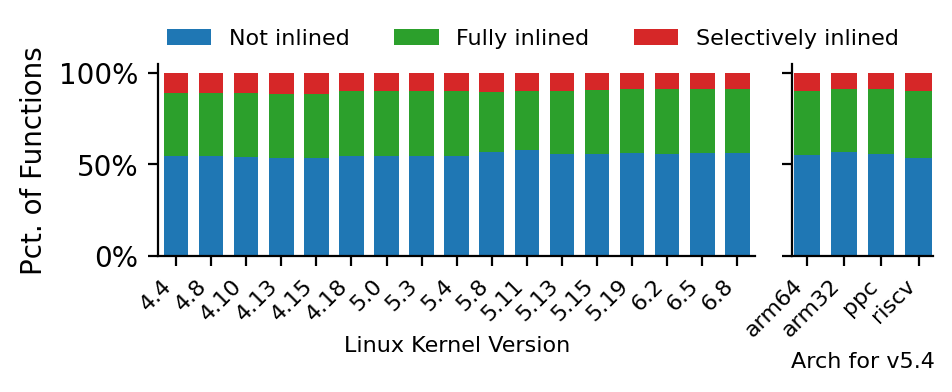

In [5]:
from typing import List

from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from matplotlib.ticker import FuncFormatter

from depsurf import InlineType, VersionGroup
from utils import get_legend_handles_labels, save_fig, ARCH_NAMES

COLORS = {
    InlineType.NO: "tab:blue",
    InlineType.FULL: "tab:green",
    InlineType.SELECTIVE: "tab:red",
}

NAMES = {
    InlineType.NO: "Not inlined",
    InlineType.FULL: "Fully inlined",
    InlineType.SELECTIVE: "Selectively inlined",
}

GROUPS = {
    VersionGroup.REGULAR: "Linux Kernel Version",
    VersionGroup.ARCH: "Arch for v5.4",
}

fig, axs = plt.subplots(
    1,
    len(data),
    figsize=(5, 1.25),
    sharey=True,
    width_ratios=[len(v) for v in data.values()],
    gridspec_kw={"wspace": 0.1},
)

axs: List[Axes]

for group_idx, (ax, (group, group_data)) in enumerate(zip(axs, data.items())):
    for i, (version, version_data) in enumerate(group_data.items()):
        bottom = 0
        for k, v in version_data.items():
            ax.bar(i, v, 0.7, label=NAMES[k], bottom=bottom, color=COLORS[k])
            bottom += v

    if group == VersionGroup.REGULAR:
        labels = [v.short_version for v in group_data]
    elif group == VersionGroup.ARCH:
        labels = [ARCH_NAMES[v.arch] for v in group_data]

    ax.set_xticks(range(len(labels)), labels)
    ax.set_xlabel(GROUPS[group], fontsize=8)
    ax.set_xticklabels(labels, fontsize=8, rotation=45, ha="right", va="top")

    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0%}"))

axs[0].set_ylabel("Pct. of Functions")

handles, labels = get_legend_handles_labels(fig)
fig.legend(
    handles,
    labels,
    loc="upper center",
    ncol=5,
    bbox_to_anchor=(0.5, 1.1),
    fontsize=8,
)

save_fig(fig, "inline")